[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RadimKozl/JLNN/blob/main/examples/JLNN_basic_boolean_gates.ipynb)

# **JLNN – Basic Boolean Gates (AND, OR, NOT, NAND, NOR, XOR)**

This notebook shows how JLNN handles classical Boolean operations as a special case of interval logic.

What you will learn:
- Definition of each operation in JLNN syntax
- Manual inputs 0/1 (crisp) → output must be exactly 0 or 1
- What happens with slightly blurred inputs ([0.95, 1.0] instead of 1)
- Uncertainty width (U - L) as a measure of "fuzzy" deviation from classical logic

No training – pure inference.

## ***1. Installation and automatic restart***

In [ ]:
try:
    import jlnn
    from flax import nnx
    import jax.numpy as jnp
    print("✅ JLNN and JAX are ready.")
except ImportError:
    print("🚀 Installing JLNN from GitHub and fixing JAX for Colab...")
    # Instalace frameworku
    #!pip install jax-lnn --quiet
    !pip install git+https://github.com/RadimKozl/JLNN.git
    # Fix JAX/CUDA compatibility for 2026 in Colab
    !pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

    import os
    print("\n🔄 RESTARTING ENVIRONMENT... Please wait a second and then run the cell again.")
    os.kill(os.getpid(), 9)
    os.kill(os.getpid(), 9) # After this line, the cell stops and the environment restarts

🚀 Installing JLNN from GitHub and fixing JAX for Colab...
  Cloning https://github.com/RadimKozl/JLNN.git to /tmp/pip-req-build-xak8jcdo
  Running command git clone --filter=blob:none --quiet https://github.com/RadimKozl/JLNN.git /tmp/pip-req-build-xak8jcdo
  Resolved https://github.com/RadimKozl/JLNN.git to commit d9d3527ccfb41600a5e5916b50a53b9715707927
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of flax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.0/488.0 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


In [1]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"

### ***Imports***

In [2]:
import jlnn
import jax.numpy as jnp
from flax import nnx
import jax
import matplotlib.pyplot as plt

# JLNN core imports
from jlnn.nn.gates import WeightedAnd, WeightedOr, WeightedNot, WeightedNand, WeightedNor, WeightedXor
from jlnn.nn.predicates import FixedPredicate
from jlnn.symbolic.compiler import LNNFormula, PredicateNode, UnaryGateNode, BinaryGateNode

In [3]:
print("JLNN loaded.")

JLNN loaded.


## ***2. Common inputs for experiments (batch size 1)***

In [4]:
crisp_inputs = {
    "A": jnp.array([[1.0, 1.0]]),   # A = True
    "B": jnp.array([[0.0, 0.0]])    # B = False
}

In [5]:
fuzzy_inputs = {
    "A": jnp.array([[0.95, 1.0]]),  # A almost True
    "B": jnp.array([[0.05, 0.1]])   # B almost False
}

In [6]:
def run_gate(rule, inputs):
    model = LNNFormula(rule, nnx.Rngs(42))

    # Key override: replace LearnedPredicate with Fixed (identity)
    for name in inputs:
        if name in model.predicates:
            model.predicates[name].predicate = FixedPredicate()

    output = model(inputs)

    # Fuse L <= U (although it should already be OK)
    output = jnp.sort(output, axis=-1)

    L = output[0, 0].item()
    U = output[0, 1].item()
    width = U - L

    print(f"Rule: {rule}")
    print(f"  Output: [{L:.4f}, {U:.4f}] (width {width:.4f})")

    return L, U, width

## ***3. AND***

In [7]:
print("=== AND ===")
run_gate("A & B", crisp_inputs)   # we expect [0,0]
run_gate("A & B", fuzzy_inputs)   # we expect low values ​​+ small width

=== AND ===
Rule: A & B
  Output: [0.0000, 0.0000] (width 0.0000)
Rule: A & B
  Output: [0.0000, 0.1000] (width 0.1000)


(0.0, 0.10000002384185791, 0.10000002384185791)

## ***4. OR***

In [8]:
print("=== OR ===")
run_gate("A | B", crisp_inputs)   # we expect [1,1]
run_gate("A | B", fuzzy_inputs)   # we expect high values

=== OR ===
Rule: A | B
  Output: [1.0000, 1.0000] (width 0.0000)
Rule: A | B
  Output: [1.0000, 1.0000] (width 0.0000)


(1.0, 1.0, 0.0)

## ***5. NOT***

In [9]:
print("=== NOT ===")
run_gate("~A", {"A": crisp_inputs["A"]})  # we expect [0,0]
run_gate("~A", {"A": fuzzy_inputs["A"]})  # we expect low values

=== NOT ===
Rule: ~A
  Output: [0.0000, 0.0000] (width 0.0000)
Rule: ~A
  Output: [0.0000, 0.0500] (width 0.0500)


(0.0, 0.050000011920928955, 0.050000011920928955)

In [10]:
print("=== NOT ===")
run_gate("~B", {"B": crisp_inputs["B"]})
run_gate("~B", {"B": fuzzy_inputs["B"]})

=== NOT ===
Rule: ~B
  Output: [1.0000, 1.0000] (width 0.0000)
Rule: ~B
  Output: [0.9000, 0.9500] (width 0.0500)


(0.8999999761581421, 0.949999988079071, 0.050000011920928955)

## ***6. NAND, NOR, XOR***

In [11]:
print("=== NAND ===")
run_gate("~(A & B)", crisp_inputs)

=== NAND ===
Rule: ~(A & B)
  Output: [1.0000, 1.0000] (width 0.0000)


(1.0, 1.0, 0.0)

In [12]:
print("=== NOR ===")
run_gate("~(A | B)", crisp_inputs)

=== NOR ===
Rule: ~(A | B)
  Output: [0.0000, 0.0000] (width 0.0000)


(0.0, 0.0, 0.0)

In [13]:
print("=== XOR ===")
run_gate("(A & ~B) | (~A & B)", crisp_inputs)
run_gate("(A & ~B) | (~A & B)", fuzzy_inputs)   # interesting – XOR is sensitive to uncertainty

=== XOR ===
Rule: (A & ~B) | (~A & B)
  Output: [1.0000, 1.0000] (width 0.0000)
Rule: (A & ~B) | (~A & B)
  Output: [0.8500, 0.9500] (width 0.1000)


(0.8499999642372131, 0.949999988079071, 0.10000002384185791)

## ***7. Visualization of all operations (bar chart)***

In [14]:
gates = ["AND", "OR", "NOT A", "NAND", "NOR", "XOR"]
crisp_widths = []
fuzzy_widths = []

In [15]:
for gate in gates:
    # Crisp
    if gate == "NOT A":
        rule = "~A"
        inp = {"A": crisp_inputs["A"]}
    elif gate == "XOR":
        rule = "(A & ~B) | (~A & B)"
        inp = crisp_inputs
    else:
        rule = f"A {'&' if 'AND' in gate or 'NAND' in gate else '|'} B"
        if 'NAND' in gate or 'NOR' in gate:
            rule = f"~({rule})"
        inp = crisp_inputs

    _, _, w_crisp = run_gate(rule, inp)
    crisp_widths.append(w_crisp)

    # Fuzzy – we correctly pass the keys from inp
    inp_f = {key: fuzzy_inputs[key] for key in inp}
    _, _, w_fuzzy = run_gate(rule, inp_f)
    fuzzy_widths.append(w_fuzzy)

Rule: A & B
  Output: [0.0000, 0.0000] (width 0.0000)
Rule: A & B
  Output: [0.0000, 0.1000] (width 0.1000)
Rule: A | B
  Output: [1.0000, 1.0000] (width 0.0000)
Rule: A | B
  Output: [1.0000, 1.0000] (width 0.0000)
Rule: ~A
  Output: [0.0000, 0.0000] (width 0.0000)
Rule: ~A
  Output: [0.0000, 0.0500] (width 0.0500)
Rule: ~(A & B)
  Output: [1.0000, 1.0000] (width 0.0000)
Rule: ~(A & B)
  Output: [0.9000, 1.0000] (width 0.1000)
Rule: ~(A | B)
  Output: [0.0000, 0.0000] (width 0.0000)
Rule: ~(A | B)
  Output: [0.0000, 0.0000] (width 0.0000)
Rule: (A & ~B) | (~A & B)
  Output: [1.0000, 1.0000] (width 0.0000)
Rule: (A & ~B) | (~A & B)
  Output: [0.8500, 0.9500] (width 0.1000)


In [16]:
# Check lengths (debug)
print(f"Gates: {len(gates)}")
print(f"Crisp widths: {len(crisp_widths)}")
print(f"Fuzzy widths: {len(fuzzy_widths)}")

Gates: 6
Crisp widths: 6
Fuzzy widths: 6


In [17]:
# If duplicates – take only the last unique values ​​(if the loop ran twice)
if len(crisp_widths) > len(gates):
    crisp_widths = crisp_widths[-len(gates):]
    fuzzy_widths = fuzzy_widths[-len(gates):]

### ***Bar chart***

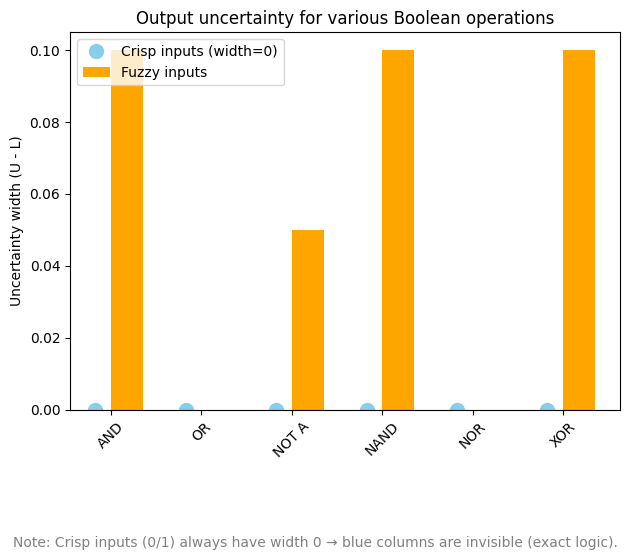

In [18]:
x = range(len(gates))
bar_width = 0.35

# Fuzzy – full columns
plt.bar([i + bar_width/2 for i in x], fuzzy_widths, width=bar_width, label='Fuzzy inputs', color='orange')

# Crisp – thin columns or just dots at zero
for i, w in enumerate(crisp_widths):
    if w > 0:
        plt.bar(i - bar_width/2, w, width=bar_width, color='skyblue', label='Crisp inputs' if i == 0 else "")
    else:
        plt.plot(i - bar_width/2, 0, 'o', color='skyblue', markersize=10, label='Crisp inputs (width=0)' if i == 0 else "")

plt.xticks(x, gates, rotation=45)
plt.ylabel('Uncertainty width (U - L)')
plt.title('Output uncertainty for various Boolean operations')
plt.legend()
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)
plt.tight_layout()
plt.figtext(0.5, -0.15,
            "Note: Crisp inputs (0/1) always have width 0 → blue columns are invisible (exact logic).",
            ha='center', fontsize=10, color='gray')
plt.show()

## ***Summary***
- JLNN processes classical Boolean operations as a special case of interval logic.
- With crisp inputs (L=U=0 or 1) the output is exactly 0 or 1 (no uncertainty).
- With fuzzy inputs, uncertainty is transferred to the output – XOR is the weakest, NOT is the strongest in transferring uncertainty.
